<h1 align="center">SpaCy Tutorial from SpaCy Team</h1>

## Chapter 4: Training a neural network model
https://course.spacy.io/en/chapter4

In this chapter, you'll learn how to update spaCy's statistical models to customize them for your use case – for example, to predict a new entity type in online comments. You'll write your own training loop from scratch, and understand the basics of how training works, along with tips and tricks that can make your custom NLP projects more successful.

### 1: Training and updating models

#### Why updating the model?
---
- Better results on your specific domain
- Learn classification schemes specifically for your problem
- Essential for text classification
- Very useful for named entity recognition
- Less critical for part-of-speech tagging and dependency parsing

#### How training works (1)
---
1. Initialize the model weights randomly with ```nlp.begin_training```
2. Predict a few examples with the current weights by calling ```nlp.update```
3. Compare prediction with true labels
4. Calculate how to change weights to improve predictions
5. Update weights slightly
6. Go back to 2.

#### How training works (2)
---
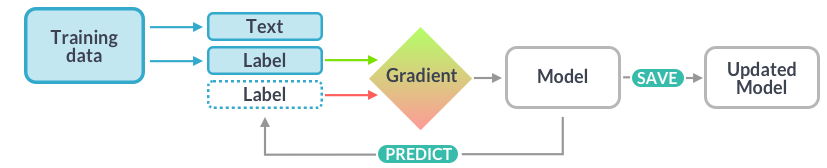
- **Training data:** Examples and their annotations.
- **Text:** The input text the model should predict a label for.
- **Label:** The label the model should predict.
- **Gradient:** How to change the weights.

#### Example: Training the entity recognizer
---
- The entity recognizer tags words and phrases in context
- Each token can only be part of one entity
- Examples need to come with context

```("iPhone X is coming", {"entities": [(0, 8, "GADGET")]})```
- Texts with no entities are also important
```("I need a new phone! Any tips?", {"entities": []})```
- **Goal:** teach the model to generalize

#### The training data
---
- Examples of what we want the model to predict in context
- Update an **existing model:** a few hundred to a few thousand examples
- Train a **new category:** a few thousand to a million examples
    - spaCy's English models: 2 million words
- Usually created manually by human annotators
- Can be semi-automated – for example, using spaCy's **```Matcher```**!

### 2: Purpose of training
While spaCy comes with a range of pre-trained models to predict linguistic annotations, you almost always want to fine-tune them with more examples. You can do this by training them with more labelled data.

What does training not help with?<br>
**Solution:*** Discover patterns in unlabelled data.

### 3: Creating training data (1)
spaCy’s rule-based ```Matcher``` is a great way to quickly create training data for named entity models. A list of sentences is available as the variable ```TEXTS```. You can print it to inspect it. We want to find all mentions of different iPhone models, so we can create training data to teach a model to recognize them as ```"GADGET"```.

- Write a pattern for two tokens whose lowercase forms match ```"iphone"``` and ```"x"```.
- Write a pattern for two tokens: one token whose lowercase form matches ```"iphone"``` and a digit.

In [1]:
import json
from spacy.matcher import Matcher
from spacy.lang.en import English

with open("data/iphone.json") as f:
    TEXTS = json.loads(f.read())

nlp = English()
matcher = Matcher(nlp.vocab)

# Two tokens whose lowercase forms match "iphone" and "x"
pattern1 = [{"LOWER": "iphone"}, {"LOWER": "x"}]

# Token whose lowercase form matches "iphone" and a digit
pattern2 = [{"LOWER": "iphone"}, {"IS_DIGIT": True}]

# Add patterns to the matcher and check the result
matcher.add("GADGET", None, pattern1, pattern2)
for doc in nlp.pipe(TEXTS):
    print([doc[start:end] for match_id, start, end in matcher(doc)])

[iPhone X]
[iPhone X]
[iPhone X]
[iPhone 8]
[iPhone 11, iPhone 8]
[]


### 4: Creating training data (2)
Let’s use the match patterns we’ve created in the previous exercise to bootstrap a set of training examples. A list of sentences is available as the variable ```TEXTS```.

- Create a doc object for each text using ```nlp.pipe```.
- Match on the ```doc``` and create a list of matched spans.
- Get ```(start character, end character, label)``` tuples of matched spans.
- Format each example as a tuple of the text and a dict, mapping ```"entities"``` to the entity tuples.
- Append the example to ```TRAINING_DATA``` and inspect the printed data.

In [2]:
import json
from spacy.matcher import Matcher
from spacy.lang.en import English

with open("data/iphone.json") as f:
    TEXTS = json.loads(f.read())

nlp = English()
matcher = Matcher(nlp.vocab)
pattern1 = [{"LOWER": "iphone"}, {"LOWER": "x"}]
pattern2 = [{"LOWER": "iphone"}, {"IS_DIGIT": True}]
matcher.add("GADGET", None, pattern1, pattern2)

TRAINING_DATA = []

# Create a Doc object for each text in TEXTS
for doc in nlp.pipe(TEXTS):
    # Match on the doc and create a list of matched spans
    spans = [doc[start:end] for match_id, start, end in matcher(doc)]
    # Get (start character, end character, label) tuples of matches
    entities = [(span.start_char, span.end_char, "GADGET") for span in spans]
    # Format the matches as a (doc.text, entities) tuple
    training_example = (doc.text, {"entities": entities})
    # Append the example to the training data
    TRAINING_DATA.append(training_example)

print(*TRAINING_DATA, sep="\n")

('How to preorder the iPhone X', {'entities': [(20, 28, 'GADGET')]})
('iPhone X is coming', {'entities': [(0, 8, 'GADGET')]})
('Should I pay $1,000 for the iPhone X?', {'entities': [(28, 36, 'GADGET')]})
('The iPhone 8 reviews are here', {'entities': [(4, 12, 'GADGET')]})
("iPhone 11 vs iPhone 8: What's the difference?", {'entities': [(0, 9, 'GADGET'), (13, 21, 'GADGET')]})
('I need a new phone! Any tips?', {'entities': []})


### 5: The training loop

#### The steps of a training loop
---
1. Loop for a number of times.
2. Shuffle the training data.
3. Divide the data into batches.
4. Update the model for each batch.
5. Save the updated model.

#### Recap: How training works
---
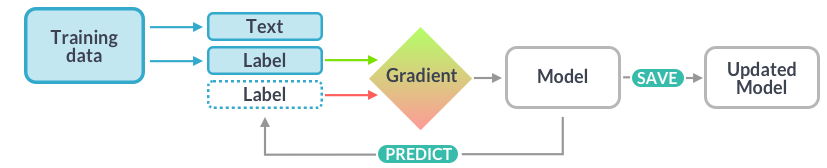
- **Training data:** Examples and their annotations.
- **Text:** The input text the model should predict a label for.
- **Label:** The label the model should predict.
- **Gradient:** How to change the weights.

#### Example loop
---
```Python
TRAINING_DATA = [
    ("How to preorder the iPhone X", {"entities": [(20, 28, "GADGET")]})
    # And many more examples...
]
```
```Python
# Loop for 10 iterations
for i in range(10):
    # Shuffle the training data
    random.shuffle(TRAINING_DATA)
    # Create batches and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA):
        # Split the batch in texts and annotations
        texts = [text for text, annotation in batch]
        annotations = [annotation for text, annotation in batch]
        # Update the model
        nlp.update(texts, annotations)

# Save the model
nlp.to_disk(path_to_model)
```

#### Updating an existing model
---
- Improve the predictions on new data
- Especially useful to improve existing categories, like ```"PERSON"```
- Also possible to add new categories
- Be careful and make sure the model doesn't "forget" the old ones

#### Setting up a new pipeline from scratch
---
```Python
# Start with blank English model
nlp = spacy.blank("en")
# Create blank entity recognizer and add it to the pipeline
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)
# Add a new label
ner.add_label("GADGET")

# Start the training
nlp.begin_training()
# Train for 10 iterations
for itn in range(10):
    random.shuffle(examples)
    # Divide examples into batches
    for batch in spacy.util.minibatch(examples, size=2):
        texts = [text for text, annotation in batch]
        annotations = [annotation for text, annotation in batch]
        # Update the model
        nlp.update(texts, annotations)
```

### 6: Setting up the pipeline
In this exercise, you’ll prepare a spaCy pipeline to train the entity recognizer to recognize ```"GADGET"``` entities in a text – for example, “iPhone X”.

- Create a blank ```"en"``` model, for example using the ```spacy.blank``` method.
- Create a new entity recognizer using ```nlp.create_pipe``` and add it to the pipeline.
- Add the new label ```"GADGET"``` to the entity recognizer using the ```add_label``` method on the pipeline component.

In [3]:
import spacy

# Create a blank "en" model
nlp = spacy.blank("en")

# Create a new entity recognizer and add it to the pipeline
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)

# Add the label "GADGET" to the entity recognizer
ner.add_label("GADGET")

### 7: Building a training loop
Let’s write a simple training loop from scratch!

The pipeline you’ve created in the previous exercise is available as the ```nlp``` object. It already contains the entity recognizer with the added label ```"GADGET"```.

The small set of labelled examples that you’ve created previously is available as ```TRAINING_DATA```. To see the examples, you can print them in your script.

- Call ```nlp.begin_training```, create a training loop for 10 iterations and shuffle the training data.
- Create batches of training data using ```spacy.util.minibatch``` and iterate over the batches.
- Convert the ```(text, annotations)``` tuples in the batch to lists of ```texts``` and ```annotations```.
- For each batch, use ```nlp.update``` to update the model with the texts and annotations.

In [4]:
import spacy
import random
import json

with open("data/gadgets.json") as f:
    TRAINING_DATA = json.loads(f.read())
print(TRAINING_DATA)

nlp = spacy.blank("en")
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)
ner.add_label("GADGET")

# Start the training
nlp.begin_training()

# Loop for 10 iterations
for itn in range(10):
    # Shuffle the training data
    random.shuffle(TRAINING_DATA)
    losses = {}

    # Batch the examples and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA, size=2):
        texts = [text for text, entities in batch]
        annotations = [entities for text, entities in batch]

        # Update the model
        nlp.update(texts, annotations, losses=losses)
    print(losses)

[['How to preorder the iPhone X', {'entities': [[20, 28, 'GADGET']]}], ['iPhone X is coming', {'entities': [[0, 8, 'GADGET']]}], ['Should I pay $1,000 for the iPhone X?', {'entities': [[28, 36, 'GADGET']]}], ['The iPhone 8 reviews are here', {'entities': [[4, 12, 'GADGET']]}], ['Your iPhone goes up to 11 today', {'entities': [[5, 11, 'GADGET']]}], ['I need a new phone! Any tips?', {'entities': []}]]


C:\MyInstalledSoftware\Miniconda\envs\all\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs


{'ner': 32.82371121644974}
{'ner': 19.32954615354538}
{'ner': 7.284760659560561}
{'ner': 5.862286069721449}
{'ner': 8.28629943190299}
{'ner': 4.971785849193111}
{'ner': 2.1707026007212846}
{'ner': 0.9227093736154961}
{'ner': 2.218165790701118}
{'ner': 0.8083313332307739}


### 8: Exploring the model

Let’s see how the model performs on unseen data! To speed things up a little, we already ran a trained model for the label "GADGET" over some text. Here are some of the results:

|Text|Entities|
|-----|-----|
|Apple is slowing down the iPhone 8 and iPhone X - how to stop it|(iPhone 8, iPhone X)|
|I finally understand what the iPhone X ‘notch’ is for|(iPhone X,)|
|Everything you need to know about the Samsung Galaxy S9|(Samsung Galaxy,)|
|Looking to compare iPad models? Here’s how the 2018 lineup stacks up|(iPad,)|
|The iPhone 8 and iPhone 8 Plus are smartphones designed, developed, and marketed by Apple|(iPhone 8, iPhone 8)|
|what is the cheapest ipad, especially ipad pro???|(ipad, ipad)|
|Samsung Galaxy is a series of mobile computing devices designed, manufactured and marketed by Samsung Electronics|(Samsung Galaxy,)|

Out of all the entities in the texts, how many did the model get correct? Keep in mind that incomplete entity spans count as mistakes, too! Tip: Count the number of entities that the model should have predicted. Then count the number of entities it actually predicted correctly and divide it by the number of total correct entities.

**Solution:** 70%

### 9: Training best practices

#### Problem 1: Models can "forget" things
---
- Existing model can overfit on new data
    - e.g.: if you only update it with ```"WEBSITE"```, it can "unlearn" what a ```"PERSON"``` is
- Also known as "catastrophic forgetting" problem

#### Solution 1: Mix in previously correct predictions
---
- For example, if you're training "WEBSITE", also include examples of "PERSON"
- Run existing spaCy model over data and extract all other relevant entities

#### BAD:
<code>
TRAINING_DATA = [
    ("Reddit is a website", {"entities": [(0, 6, "WEBSITE")]})
]
</code>

#### GOOD:
<code>
TRAINING_DATA = [
    ("Reddit is a website", {"entities": [(0, 6, "WEBSITE")]}),
    ("Obama is a person", {"entities": [(0, 5, "PERSON")]})
]
</code>

#### Problem 2: Models can't learn everything
---
- spaCy's models make predictions based on local context
- Model can struggle to learn if decision is difficult to make based on context
- Label scheme needs to be consistent and not too specific
    - For example: ```"CLOTHING"``` is better than ```"ADULT_CLOTHING"``` and ```"CHILDRENS_CLOTHING"```

#### Solution 2: Plan your label scheme carefully
---
- Pick categories that are reflected in local context
- More generic is better than too specific
- Use rules to go from generic labels to specific categories

#### BAD:
```LABELS = ["ADULT_SHOES", "CHILDRENS_SHOES", "BANDS_I_LIKE"]```

#### GOOD:
```LABELS = ["CLOTHING", "BAND"]```

### 10: Good data vs. bad data
Here’s an excerpt from a training set that labels the entity type ```TOURIST_DESTINATION``` in traveler reviews.

```Python
TRAINING_DATA = [
    (
        "i went to amsterdem last year and the canals were beautiful",
        {"entities": [(10, 19, "TOURIST_DESTINATION")]},
    ),
    (
        "You should visit Paris once in your life, but the Eiffel Tower is kinda boring",
        {"entities": [(17, 22, "TOURIST_DESTINATION")]},
    ),
    ("There's also a Paris in Arkansas, lol", {"entities": []}),
    (
        "Berlin is perfect for summer holiday: lots of parks, great nightlife, cheap beer!",
        {"entities": [(0, 6, "TOURIST_DESTINATION")]},
    ),
]
```

#### Part 1
Why is this data and label scheme problematic?
1. Whether a place is a tourist destination is a subjective judgement and not a definitive category. It will be very difficult for the entity recognizer to learn.
2. Paris should also be labelled as tourist destinations for consistency. Otherwise, the model will be confused.
3. Rare out-of-vocabulary words like the misspelled 'amsterdem' shouldn't be labelled as entities.
**Solution:** 1<br>
A much better approach would be to only label "GPE" (geopolitical entity) or "LOCATION" and then use a rule-based system to determine whether the entity is a tourist destination in this context. For example, you could resolve the entities types back to a knowledge base or look them up in a travel wiki.

#### Part 2
- Rewrite the ```TRAINING_DATA``` to only use the label ```"GPE"``` (cities, states, countries) instead of ```"TOURIST_DESTINATION"```.
- Don’t forget to add tuples for the ```"GPE"``` entities that weren’t labeled in the old data.

```Python
TRAINING_DATA = [
    (
        "i went to amsterdem last year and the canals were beautiful",
        {"entities": [(10, 19, "TOURIST_DESTINATION")]},
    ),
    (
        "You should visit Paris once in your life, but the Eiffel Tower is kinda boring",
        {"entities": [(17, 22, "TOURIST_DESTINATION")]},
    ),
    ("There's also a Paris in Arkansas, lol", {"entities": []}),
    (
        "Berlin is perfect for summer holiday: lots of parks, great nightlife, cheap beer!",
        {"entities": [(0, 6, "TOURIST_DESTINATION")]},
    ),
]
```

```Python
TRAINING_DATA = [
    (
        "i went to amsterdem last year and the canals were beautiful",
        {"entities": [(10, 19, "GPE")]},
    ),
    (
        "You should visit Paris once in your life, but the Eiffel Tower is kinda boring",
        {"entities": [(17, 22, "GPE")]},
    ),
    ("There's also a Paris in Arkansas, lol", {"entities": [(15, 20, "GPE"), (24, 32, "GPE")]}),
    (
        "Berlin is perfect for summer holiday: lots of parks, great nightlife, cheap beer!",
        {"entities": [(0, 6, "GPE")]},
    ),
]
```

### 11: Training multiple labels
Here’s a small sample of a dataset created to train a new entity type ```"WEBSITE"```. The original dataset contains a few thousand sentences. In this exercise, you’ll be doing the labeling by hand. In real life, you probably want to automate this and use an annotation tool – for example, <a href="http://brat.nlplab.org/">Brat</a>, a popular open-source solution, or <a href="https://prodi.gy/">Prodigy</a>, our own annotation tool that integrates with spaCy.

#### Part 1
- Complete the entity offsets for the ```"WEBSITE"``` entities in the data. Feel free to use ```len()``` if you don’t want to count the characters.

```Python
TRAINING_DATA = [
    (
        "Reddit partners with Patreon to help creators build communities",
        {"entities": [(0, 6, "WEBSITE"), (21, 28, "WEBSITE")]},
    ),
    ("PewDiePie smashes YouTube record", {"entities": [(18, 25, "WEBSITE")]}),
    (
        "Reddit founder Alexis Ohanian gave away two Metallica tickets to fans",
        {"entities": [(0, 6, "WEBSITE")]},
    ),
    # And so on...
]
```

#### Part 2
A model was trained with the data you just labelled, plus a few thousand similar examples. After training, it’s doing great on "WEBSITE", but doesn’t recognize "PERSON" anymore. Why could this be happening?
1. It’s very difficult for the model to learn about different categories like ```"PERSON"``` and ```"WEBSITE"```.
2. The training data included no examples of ```"PERSON"```, so the model learned that this label is incorrect.
3. The hyperparameters need to be retuned so that both entity types can be recognized.
**Solution:** 2<br>
If ```"PERSON"``` entities occur in the training data but aren’t labelled, the model will learn that they shouldn’t be predicted. Similarly, if an existing entity type isn’t present in the training data, the model may ”forget” and stop predicting it.

#### Part 3
- Update the training data to include annotations for the ```"PERSON"``` entities “PewDiePie” and “Alexis Ohanian”.
```Python
TRAINING_DATA = [
    (
        "Reddit partners with Patreon to help creators build communities",
        {"entities": [(0, 6, "WEBSITE"), (21, 28, "WEBSITE")]},
    ),
    ("PewDiePie smashes YouTube record", {"entities": [(0, 9, "PERSON"), (18, 25, "WEBSITE")]}),
    (
        "Reddit founder Alexis Ohanian gave away two Metallica tickets to fans",
        {"entities": [(0, 6, "WEBSITE"), (15, 29, "PERSON")]},
    ),
    # And so on...
]
```

### 12: Wrapping up

#### New spaCy skills learnt
---
- Extract **linguistic features:** part-of-speech tags, dependencies, named entities
- Work with pre-trained **statistical models**
- Find words and phrases using ```Matcher``` and ```PhraseMatcher``` **match rules**
- Best practices for working with **data structures** ```Doc```, ```Token``` ```Span```, ```Vocab```, ```Lexeme```
- Find **semantic similarities** using **word vectors**
- Write custom **pipeline components** with **extension attributes**
- **Scale up** your spaCy pipelines and make them fast
- Create **training data** for spaCy' statistical models
- **Train and update** spaCy's neural network models with new data

#### More things to do with spaCy (1)
---
- <a href="https://spacy.io/usage/training">Training and updating</a> other pipeline components
    - Part-of-speech tagger
    - Dependency parser
    - Text classifier

#### More things to do with spaCy (2)
---
- <a href="https://spacy.io/usage/linguistic-features#tokenization">Customizing the tokenizer</a>
    - Adding rules and exceptions to split text differently
- <a href="https://spacy.io/usage/adding-languages">Adding or improving support for other languages</a>
    - 55+ languages currently
    - Lots of room for improvement and more languages
    - Allows training models for other languages

#### See the website for more info and documentation!
---
spacy.io